In [40]:
import import_ipynb
import cv2
from timeit import default_timer as timer
from collections import OrderedDict

from model_development import *
from extra_models import *

In [41]:
FROM_VIDEO = True
videos_path = 'Videos'
video_name = 'Virtual_Drive_Through_The_Dark_and_Foggy_Forest__Rain_and_Thunder_01_36_00___01_38_00.mp4'
video_loc = os.path.join(videos_path, video_name)

SKIP_INTERVAL = 2

In [42]:
model = LightClearNet().to(device)
state_dict_name = 'LightClearNet_2024-04-11_15-52-13_5epochs.pth'

IS_STATE_DICT_LOADING_EASY = True
NORMALIZE = False
RESIZE = True
IMG_HEIGHT = 400
WANNA_TEST = False

Datasets/RESIDE-6K/train/hazy/5730.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.3129 | PSNR: 9.0701 | SSIM: 36.33%


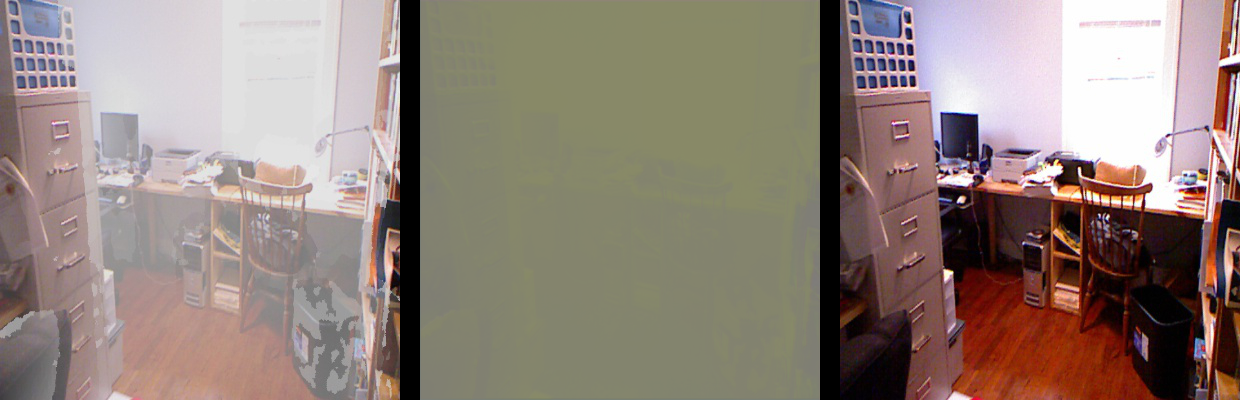

In [43]:
visualize_random_pair_pred(dataset, model, visualize_target=True, normalize=NORMALIZE)

In [44]:
state_dict_loc = os.path.join(model_save_path, state_dict_name)
print(state_dict_loc)

if IS_STATE_DICT_LOADING_EASY:
    state_dict = torch.load(state_dict_loc)
else:
    state_dict = torch.load(state_dict_loc)['state_dict']
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k[7:]
        new_state_dict[name] = v

    state_dict = new_state_dict

state_dict

models\LightClearNet_2024-04-11_15-52-13_5epochs.pth


OrderedDict([('enc_conv1.weight',
              tensor([[[[ 1.2163e-01,  2.4168e-01,  3.6777e-01],
                        [-4.4133e-02,  1.1136e-01,  2.5392e-01],
                        [ 4.0324e-02, -1.7710e-02, -4.2801e-02]],
              
                       [[ 6.7190e-02,  1.4888e-01, -6.7532e-02],
                        [-1.6951e-01, -8.6637e-02,  2.5653e-03],
                        [-2.1832e-01,  9.7840e-02, -1.3944e-01]],
              
                       [[ 1.4477e-01,  1.8476e-01,  8.7768e-02],
                        [ 6.5965e-02,  4.2435e-02, -1.7154e-01],
                        [ 4.2382e-02, -6.6074e-02, -7.0377e-02]]],
              
              
                      [[[ 3.8996e-02,  1.7626e-01,  1.0218e-01],
                        [ 1.4237e-01, -2.4492e-01, -1.5689e-01],
                        [-1.2773e-01,  7.5083e-02,  1.5827e-01]],
              
                       [[ 3.9350e-02,  1.3898e-01,  4.3450e-02],
                        [ 1.0985e-01, -3.

In [45]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Datasets/RESIDE-6K/test/hazy/1977_0.8_0.08.jpg
Image size: [1, 3, 412, 548]
L1 Loss: 0.0817 | PSNR: 19.0787 | SSIM: 88.07%


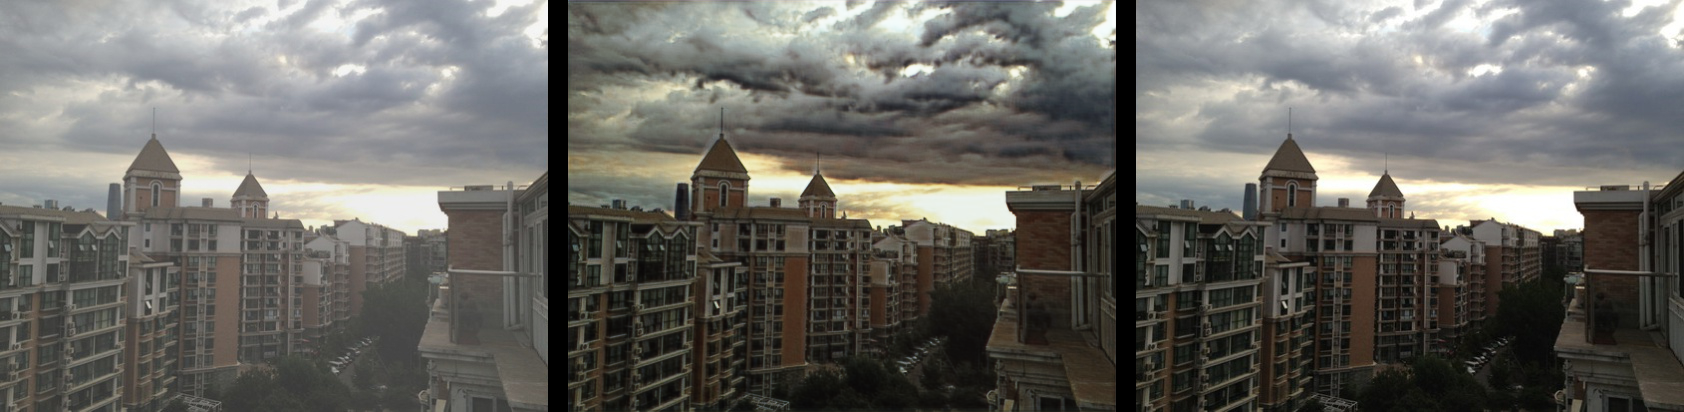

In [46]:
visualize_random_pair_pred(test_dataset, model, visualize_target=True, normalize=NORMALIZE)

In [47]:
def resize_image(image, target_height=IMG_HEIGHT):
    scale = target_height / image.height
    return image.resize((int(image.width * scale), int(image.height * scale)))

In [48]:
def frame_dehazer(frame, model):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)
    if RESIZE:
        pil_img = resize_image(pil_img)
    input = img_to_tensor(pil_img).unsqueeze(0).to(device)

    model.eval()
    with torch.inference_mode():
        output = model(input)
    if NORMALIZE:
        output = normalize_tensor(output)

    dehazed_pil_img = tensor_to_img(output.squeeze())
    new_image = visualize_pair(pil_img, dehazed_pil_img, gap=0)

    return cv2.cvtColor(np.array(new_image), cv2.COLOR_BGR2RGB)

In [49]:
cap = cv2.VideoCapture(0 if not FROM_VIDEO else video_loc)

In [50]:
start_time = timer()
                   
rendered_frames = 0
video_frames = -1

while True:
    ret, frame = cap.read()

    if not ret:
        break

    video_frames += 1
    if FROM_VIDEO and video_frames % SKIP_INTERVAL != 0:
        continue

    dehazed_frame = frame_dehazer(frame, model)
    cv2.imshow('Original vs. Dehazed Video', dehazed_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if cv2.waitKey(1) & 0xFF == ord(' '):
        while True:
            if cv2.waitKey(1) & 0xFF == ord(' '):
                break

    rendered_frames += 1

cv2.destroyAllWindows()

elapsed_time = timer() - start_time

print(f'Time Elapsed: {elapsed_time:.2f}s')
print(f'Frames: {rendered_frames} | Avg FPS: {rendered_frames/elapsed_time:.2f}')
if FROM_VIDEO:
    print(f'Video Frames: {video_frames} | Video Avg FPS: {video_frames/elapsed_time:.2f}')

Time Elapsed: 20.43s
Frames: 239 | Avg FPS: 11.70
Video Frames: 478 | Video Avg FPS: 23.40


In [51]:
cap.release()

In [52]:
if WANNA_TEST:
    loss = 0
    psnr = 0
    ssim = 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            preds = model(X)
            if NORMALIZE:
                preds = normalize_tensor(preds)

            loss += criterion(preds, y).item()
            psnr += psnr_metric(preds, y).item()
            ssim += ssim_metric(preds, y).item()

    loss /= len(test_dataloader)
    psnr /= len(test_dataloader)
    ssim /= len(test_dataloader)

    result = f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%'
    print(result)

    os.makedirs(result_save_path, exist_ok=True)
    result_file_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'
    with open(os.path.join(result_save_path, result_file_name), 'w') as f:
        f.write(result)